###**Introduction**

Le script de détection du stress est conçu pour analyser un flux vidéo et fournir des informations sur les niveaux de stress en fonction de diverses expressions faciales et du langage corporel.
###**Features**
Plusieurs caractéristiques  ont été traitées pour détecter le stress, notamment :
 * Mouvement des Mains : Analyse le mouvement des mains pour identifier des signes de stress.

 * Mouvement des Lèvres : Examine le mouvement des lèvres comme indicateur potentiel de stress.

 * Émotions : Détecte les expressions faciales pour comprendre les états émotionnels.

 * Sourcils : Surveille le mouvement et la position des sourcils pour la détection du stress.

 * Direction des Yeux : Analyse la direction dans laquelle les yeux regardent.


###**Implémentation**
L'implémentation commence par l'importation de bibliothèques essentielles telles qu'**OpenCV**, **MediaPipe**, **NumPy**, et **Matplotlib**. Ces bibliothèques jouent un rôle crucial dans le processus de détection du stress, fournissant des outils robustes pour le traitement d'images, la manipulation de données, la visualisation et la détection des points de repère faciaux.
###**Input**
Le script prend en entrée une vidéo au format standard.

###**Output**

Le script produit des tracés visuels pour chaque facteur, affichant les niveaux de stress au fil du temps. De plus, un Plot est généré, résumant les niveaux de stress pour chaque facteur.


### Installation des  bibliothèques Python  necessaires


In [1]:
!pip install mediapipe opencv-python matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 32.6 MB/s eta 0:00:00


### Importation  des dependances et creation des instances

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

mp_face_mesh = mp.solutions.face_mesh #Cette instance permet d'utiliser les fonctionnalités de suivi des traits du visage
mp_hands = mp.solutions.hands   #Cette instance permet d'utiliser les fonctionnalités de suivi des mains
mp_holistic = mp.solutions.holistic

Fonctions pour calculer différents aspects du mouvement facial et des mains,

In [4]:
def calculate_lip_movement(results):
    lip_movement = 0
    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        # Points de repère du haut de la lèvre sup
        upper_lip_landmarks = [face_landmarks.landmark[i] for i in range(61, 68)]
        # Points de repère du bas de la lèvre inf
        lower_lip_landmarks = [face_landmarks.landmark[i] for i in range(291, 298)]
        # Calcul du mouvement des lèvres
        lip_movement = sum(abs(upper_lip.x - lower_lip.x) for upper_lip, lower_lip in zip(upper_lip_landmarks, lower_lip_landmarks))
    return lip_movement



def calculate_hand_movement(results_hands, frame_width, frame_height):
    # Vérifiez que les mains sont détectées
    if results_hands.multi_hand_landmarks and len(results_hands.multi_hand_landmarks) >= 2:
        # Accédez aux positions des poignets
        left_wrist_position = results_hands.multi_hand_landmarks[0].landmark[mp_hands.HandLandmark.WRIST]
        right_wrist_position = results_hands.multi_hand_landmarks[1].landmark[mp_hands.HandLandmark.WRIST]  # Use index 1 for the right hand

        # Calculez la distance entre les poignets
        hand_distance = np.sqrt((left_wrist_position.x - right_wrist_position.x) ** 2 + (left_wrist_position.y - right_wrist_position.y) ** 2)

        # Normalisez la distance
        hand_distance /= max(frame_width, frame_height)

        # Ajoutez un facteur de mise à l'échelle pour augmenter la sensibilité
        hand_distance *= 20

        return hand_distance
    else:
        return 0

def calculate_head_movement(results_holistic):
    head_movement = 0
    if results_holistic.pose_landmarks:
        # Extraction des points de repère de la tête
        head_landmarks = results_holistic.pose_landmarks.landmark
        # Calculer le mouvement de la tête comme la position absolue moyenne sur l'axe z (profondeur) de tous les repères de la tête
        head_positions_z = [abs(landmark.z) for landmark in head_landmarks]
        head_movement = np.mean(head_positions_z)

    return head_movement


def calculate_eye_direction(results_holistic):
    if results_holistic.face_landmarks: # Vérification de la détection des points de repère du visage
        # Extraire les points de repère des yeux à partir des résultats holistiques
        face_landmarks = results_holistic.face_landmarks.landmark
        left_eye_landmarks = np.array([(landmark.x, landmark.y, landmark.z) for landmark in face_landmarks[33:46]])  # Indices for left eye landmarks
        right_eye_landmarks = np.array([(landmark.x, landmark.y, landmark.z) for landmark in face_landmarks[46:60]])  # Indices for right eye landmarks
        # Calcul de la direction de l 'oeil gauche
        left_eye_direction = (left_eye_landmarks[0] - left_eye_landmarks[1]) / np.linalg.norm((left_eye_landmarks[0] - left_eye_landmarks[1]))
        # Calcul de la direction de l 'oeil droite
        right_eye_direction = (right_eye_landmarks[0] - right_eye_landmarks[1]) / np.linalg.norm((right_eye_landmarks[0] - right_eye_landmarks[1]))
        # Calculer la moyenne de la direction des yeux
        average_eye_direction = (left_eye_direction + right_eye_direction) / 2
        return average_eye_direction
    else:
        return (0, 0, 0)  # Retourne un vecteur nul si aucun point de repère du visage n'est détecté


def calculate_eyebrows(results):
    eyebrows = 0
    if results.face_landmarks:
        face_landmarks = results.face_landmarks.landmark
        # Indices des points de repère des sourcils
        left_eyebrow_landmarks = [33, 133, 134, 135, 136, 137, 138, 139, 140, 141]
        right_eyebrow_landmarks = [263, 246, 247, 248, 249, 250, 251, 252, 253, 254]
        # Calcul du mouvement des sourcils
        left_eyebrow_movement = sum(face_landmarks[i].y for i in left_eyebrow_landmarks) / len(left_eyebrow_landmarks)
        right_eyebrow_movement = sum(face_landmarks[i].y for i in right_eyebrow_landmarks) / len(right_eyebrow_landmarks)
        # Moyenne du mouvement des deux sourcils
        eyebrows = (left_eyebrow_movement + right_eyebrow_movement) / 2
    return eyebrows

def cv2_imshow(frame):
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def generate_final_stress_description(max_values, element_names):
    # Créer la phrase en associant chaque élément à sa valeur maximale
    final_stress_description = f"Final stress = {' + '.join(f'{max_value} detected by {element}' for element, max_value in zip(element_names, max_values.values()))}"
    return final_stress_description

###  Traitement vidéo avec la détection de caractéristiques du visage, des mains  +Affichage des Plots
### Exemple 1:





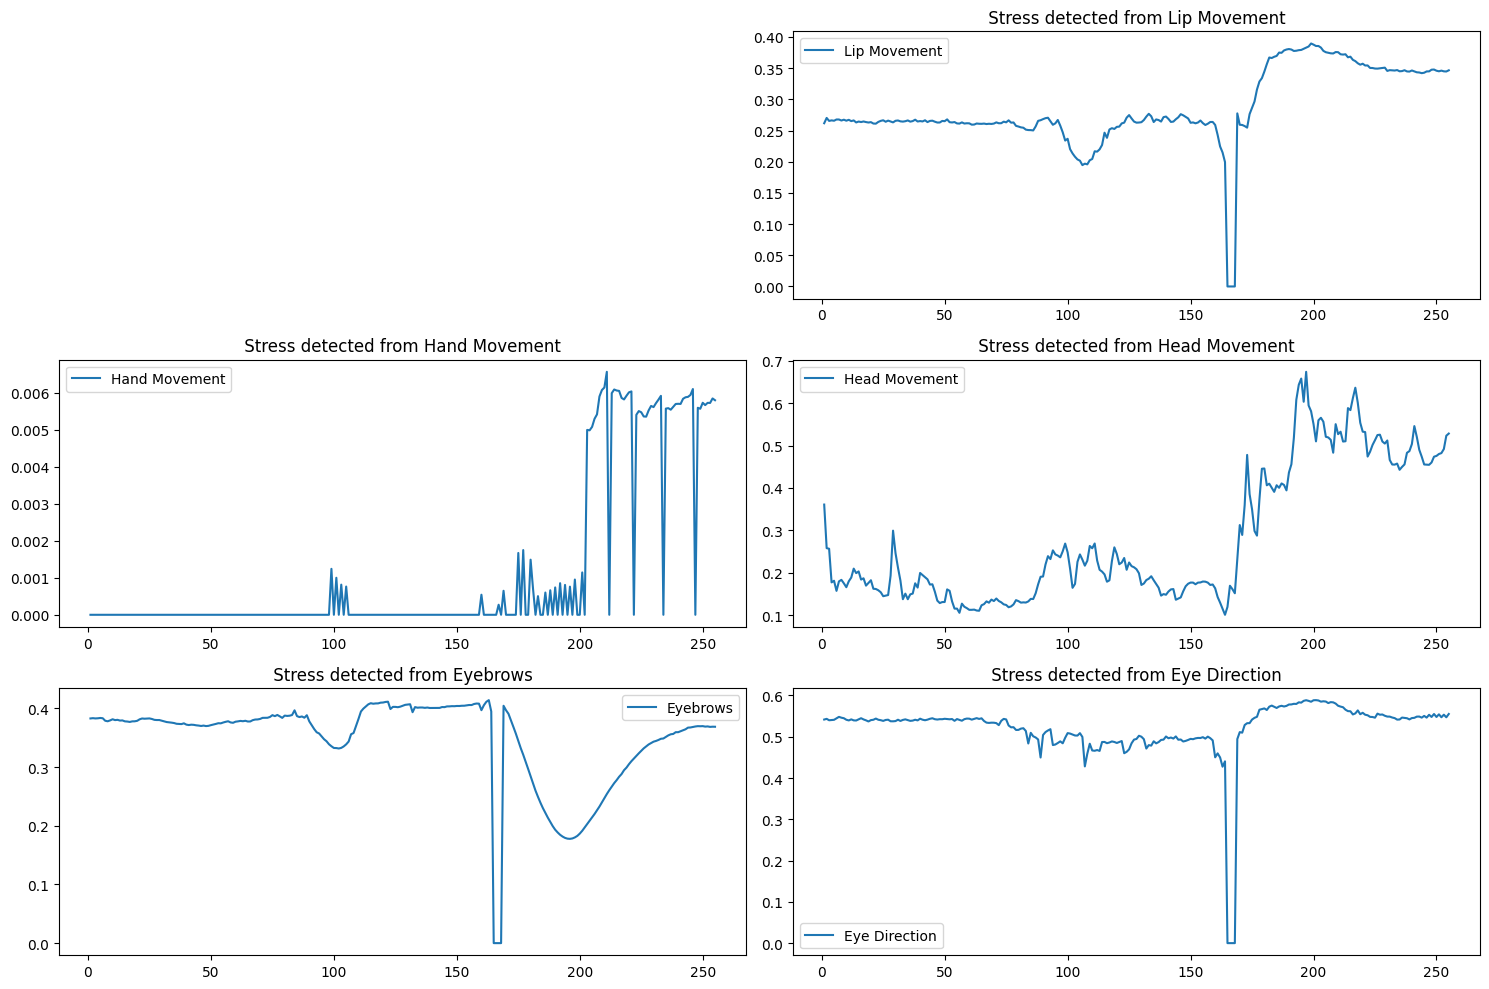

Maximum Feature Values:
Lip Movement: 0.38955235481262207
Hand Movement: 0.006571588855986154
Head Movement: 0.6741430688310753
Eyebrows: 0.4139710068702698
Eye Direction: 0.5886180072979237
Final stress = 0.38955235481262207 detected by Lip Movement + 0.006571588855986154 detected by Hand Movement + 0.6741430688310753 detected by Head Movement + 0.4139710068702698 detected by Eyebrows + 0.5886180072979237 detected by Eye Direction


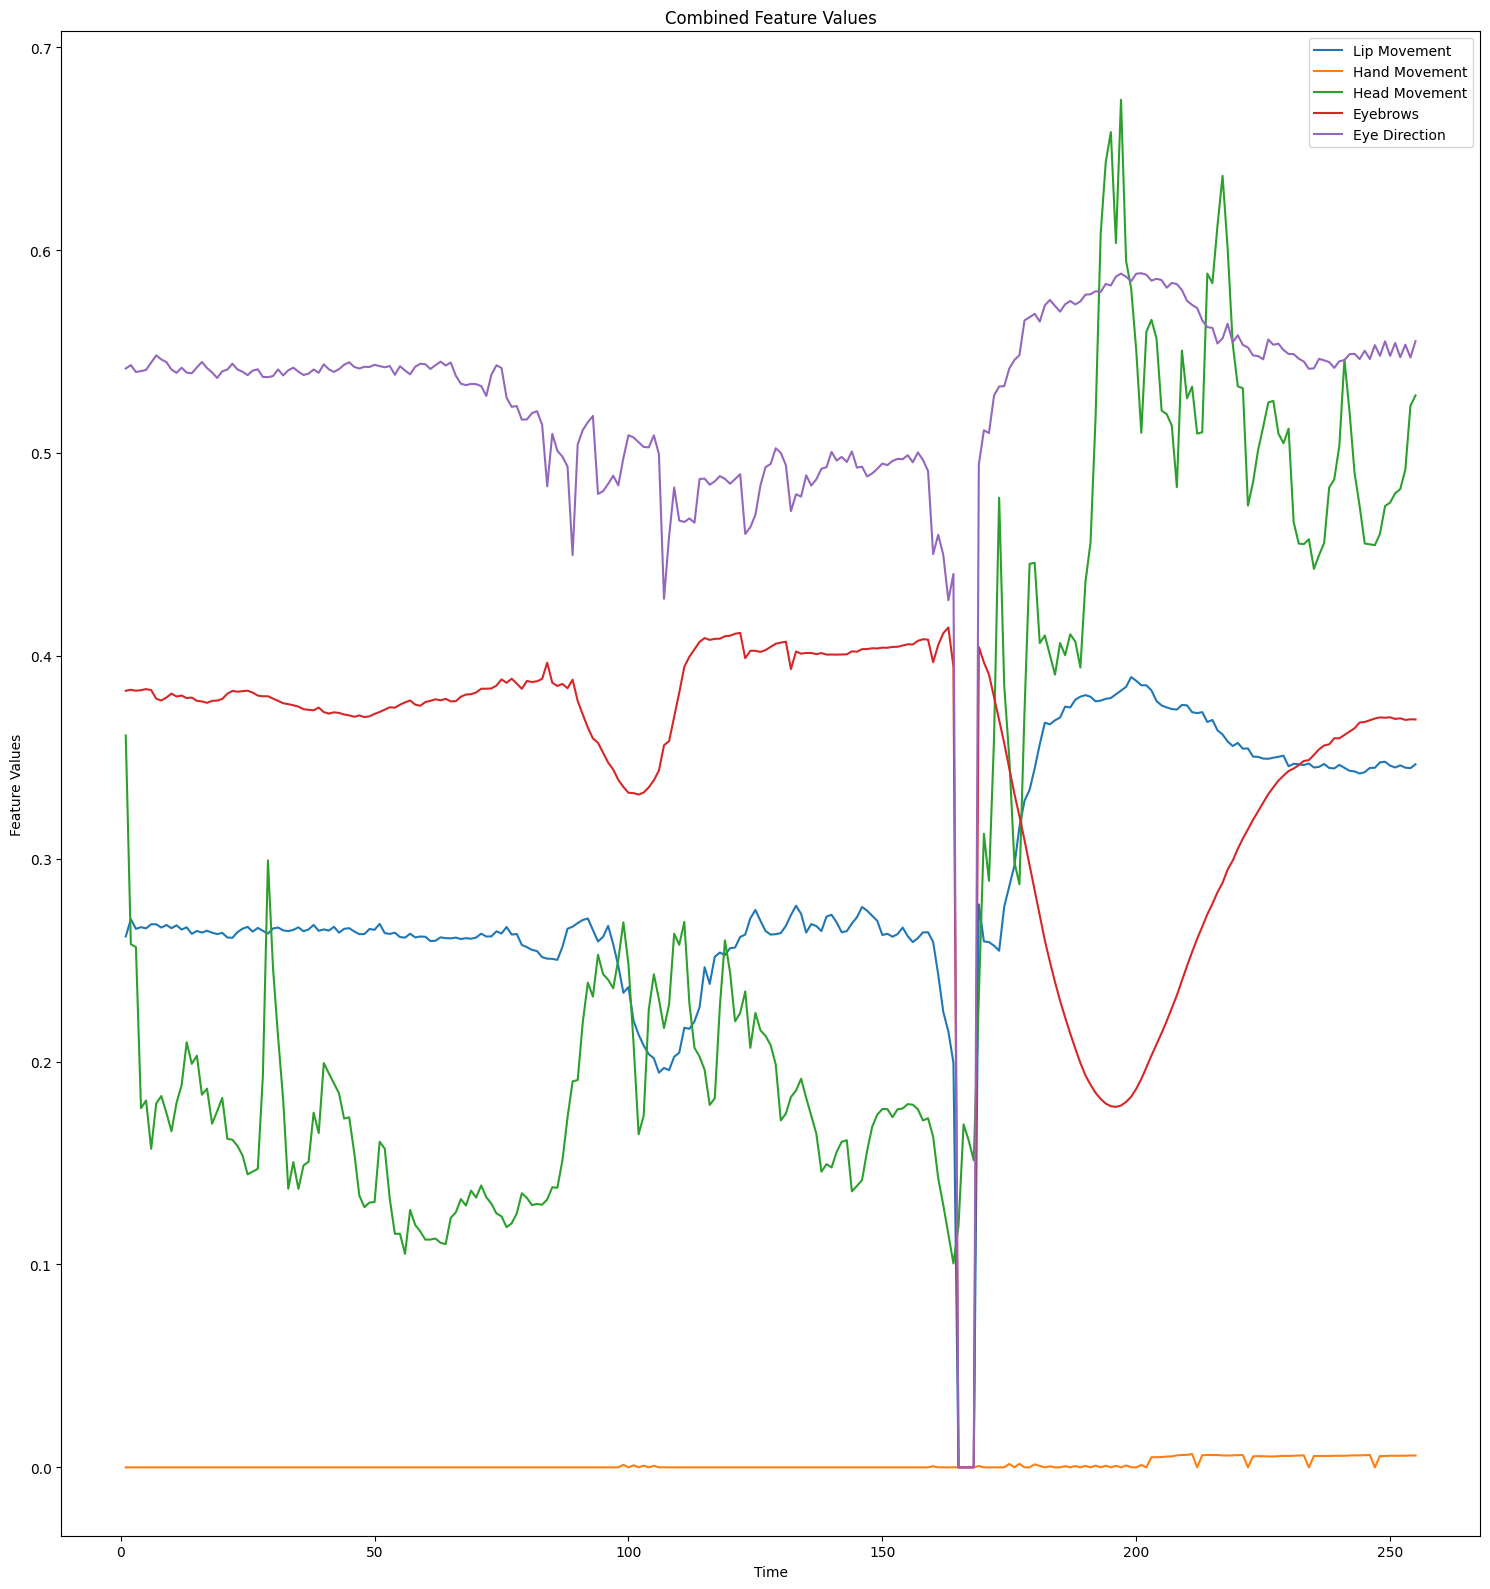

In [5]:
def process_video(video_path, feature_weights):
    cap = cv2.VideoCapture(video_path)  #lire la  video a partir du path

    with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh, \
            mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands, \
            mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:


        lip_movement_values = []
        hand_movement_values = []
        head_movement_values = []
        eyebrows_values = []
        eye_direction_values = []
        time_values = []

        frame_count = 0

        while cap.isOpened():
          # # Lecture d'une image de la vidéo
            ret, frame = cap.read()
            if not ret:
                break
            # Incrémentation du compteur d'images
            frame_count += 1
            # Obtention des dimensions de l'image
            frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
            frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Détection des traits du visage avec le détecteur Face Mesh
            results_face = face_mesh.process(rgb_frame)
            # Calcul du mouvement des lèvres
            lip_movement = calculate_lip_movement(results_face)

            # Mains: detection
            results_hands = hands.process(rgb_frame)
            hand_movement = calculate_hand_movement(results_hands, frame_width, frame_height)

            # Holistic (Head Movement, Eyebrows, Eye Direction)
            results_holistic = holistic.process(rgb_frame)
            head_movement = calculate_head_movement(results_holistic)
            eyebrows = calculate_eyebrows(results_holistic)
            eye_direction = calculate_eye_direction(results_holistic)

            # Collecter les valeurs des caractéristiques

            lip_movement_values.append(lip_movement)
            hand_movement_values.append(hand_movement)
            head_movement_values.append(head_movement)
            eyebrows_values.append(eyebrows)
            eye_direction_values.append(np.linalg.norm(eye_direction))
            time_values.append(frame_count)

        cap.release()


        # Plot  des  caractéristiques
        plt.figure(figsize=(15, 10))

        # Lip Movement
        plt.subplot(3, 2, 2)
        plt.plot(time_values, lip_movement_values, label='Lip Movement')
        plt.legend()
        plt.title(' Stress detected from Lip Movement ')

        # Hand Movement
        plt.subplot(3, 2, 3)
        plt.plot(time_values, hand_movement_values, label='Hand Movement')
        plt.legend()
        plt.title(' Stress detected from Hand Movement ')

        # Head Movement
        plt.subplot(3, 2, 4)
        plt.plot(time_values, head_movement_values, label='Head Movement')
        plt.legend()
        plt.title(' Stress detected from Head Movement ')

        # Eyebrows
        plt.subplot(3, 2, 5)
        plt.plot(time_values, eyebrows_values, label='Eyebrows')
        plt.legend()
        plt.title(' Stress detected from Eyebrows ')

        # Eye Direction
        plt.subplot(3, 2, 6)
        plt.plot(time_values, eye_direction_values, label='Eye Direction')
        plt.legend()
        plt.title(' Stress detected from Eye Direction ')

        plt.tight_layout()
        plt.show()

        # Affichege des valeurs maximales pour chacun des  features
        max_values = {
            'Lip Movement': max(lip_movement_values),
            'Hand Movement': max(hand_movement_values),
            'Head Movement': max(head_movement_values),
            'Eyebrows': max(eyebrows_values),
            'Eye Direction': max(eye_direction_values),
        }

        print("Maximum Feature Values:")
        for feature, max_value in max_values.items():
            print(f"{feature}: {max_value}")

        element_names = ['Lip Movement', 'Hand Movement', 'Head Movement', 'Eyebrows',  'Eye Direction']

        # Appel de la fonction generate_final_stress_description
        final_stress_description = generate_final_stress_description(max_values, element_names)
        # Affichage du résultat final
        print(final_stress_description)


        # Plot
        plt.figure(figsize=(15, 16))

        # Regroupement  des differents  caractériqtiques dans un seul graphe
        plt.plot(time_values, lip_movement_values, label='Lip Movement')
        plt.plot(time_values, hand_movement_values, label='Hand Movement')
        plt.plot(time_values, head_movement_values, label='Head Movement')
        plt.plot(time_values, eyebrows_values, label='Eyebrows')
        plt.plot(time_values, eye_direction_values, label='Eye Direction')

        plt.legend()
        plt.title('Aggregated results')
        plt.xlabel('Time')
        plt.ylabel('Feature Values')

        plt.tight_layout()
        plt.show()


video_path = "/content/Vid1.webm"
feature_weights = [1, 1, 1, 1, 1, 1]
process_video(video_path, feature_weights)


### Exemple 2:

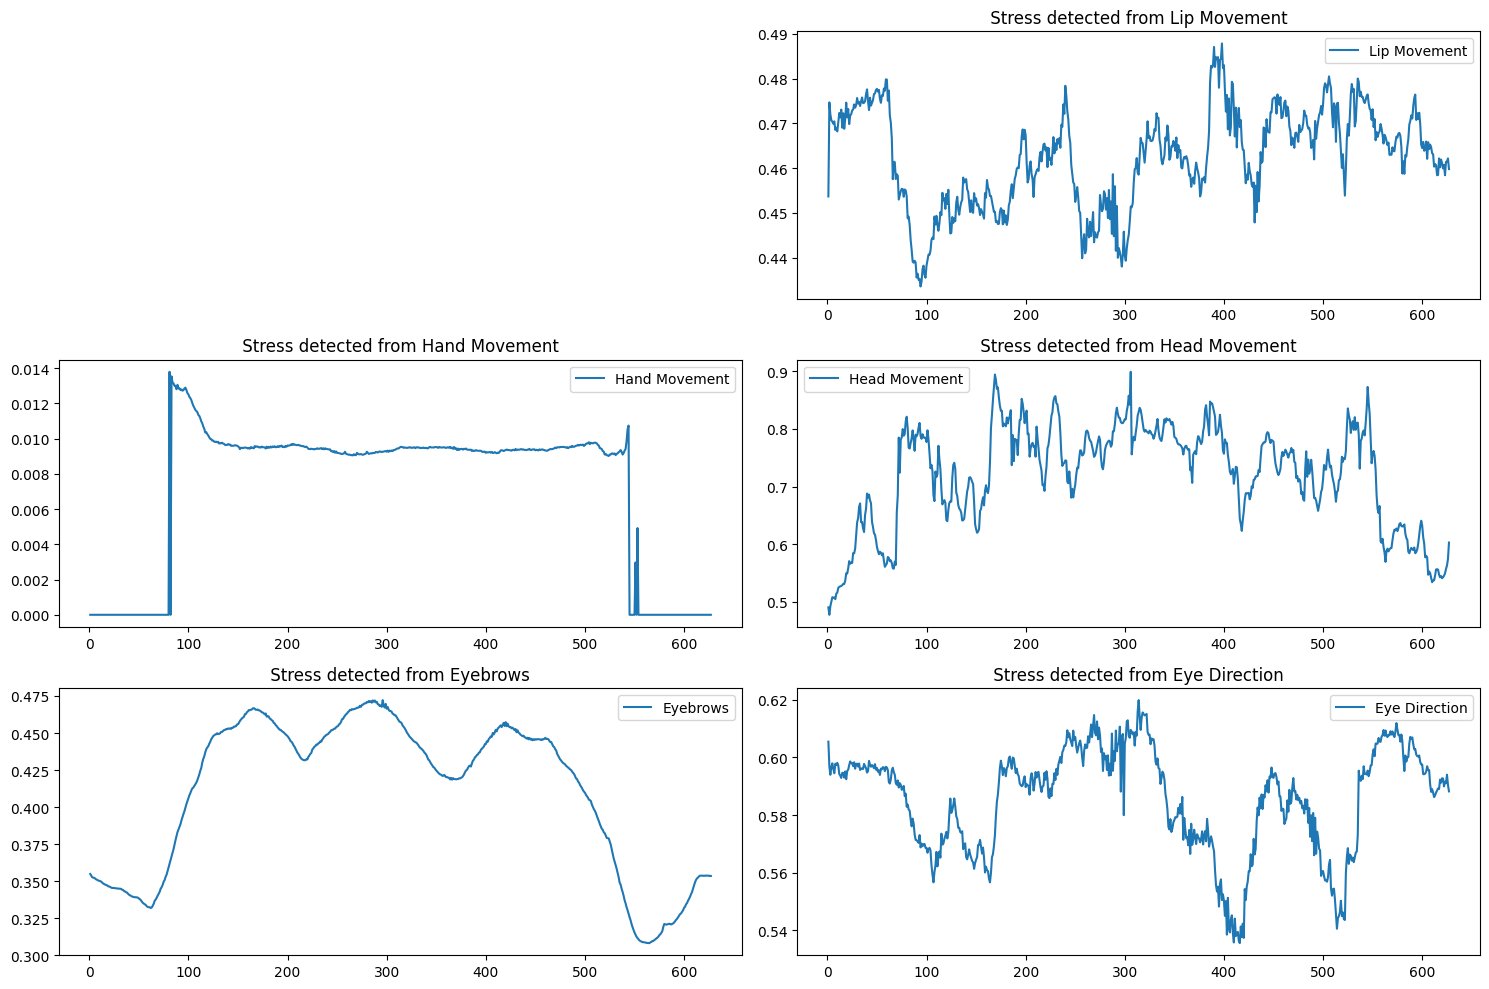

Maximum Feature Values:
Lip Movement: 0.48786020278930664
Hand Movement: 0.013796227444686884
Head Movement: 0.8989393078919613
Eyebrows: 0.4721929162740708
Eye Direction: 0.6198259325846219
Final stress = 0.48786020278930664 detected by Lip Movement + 0.013796227444686884 detected by Hand Movement + 0.8989393078919613 detected by Head Movement + 0.4721929162740708 detected by Eyebrows + 0.6198259325846219 detected by Eye Direction


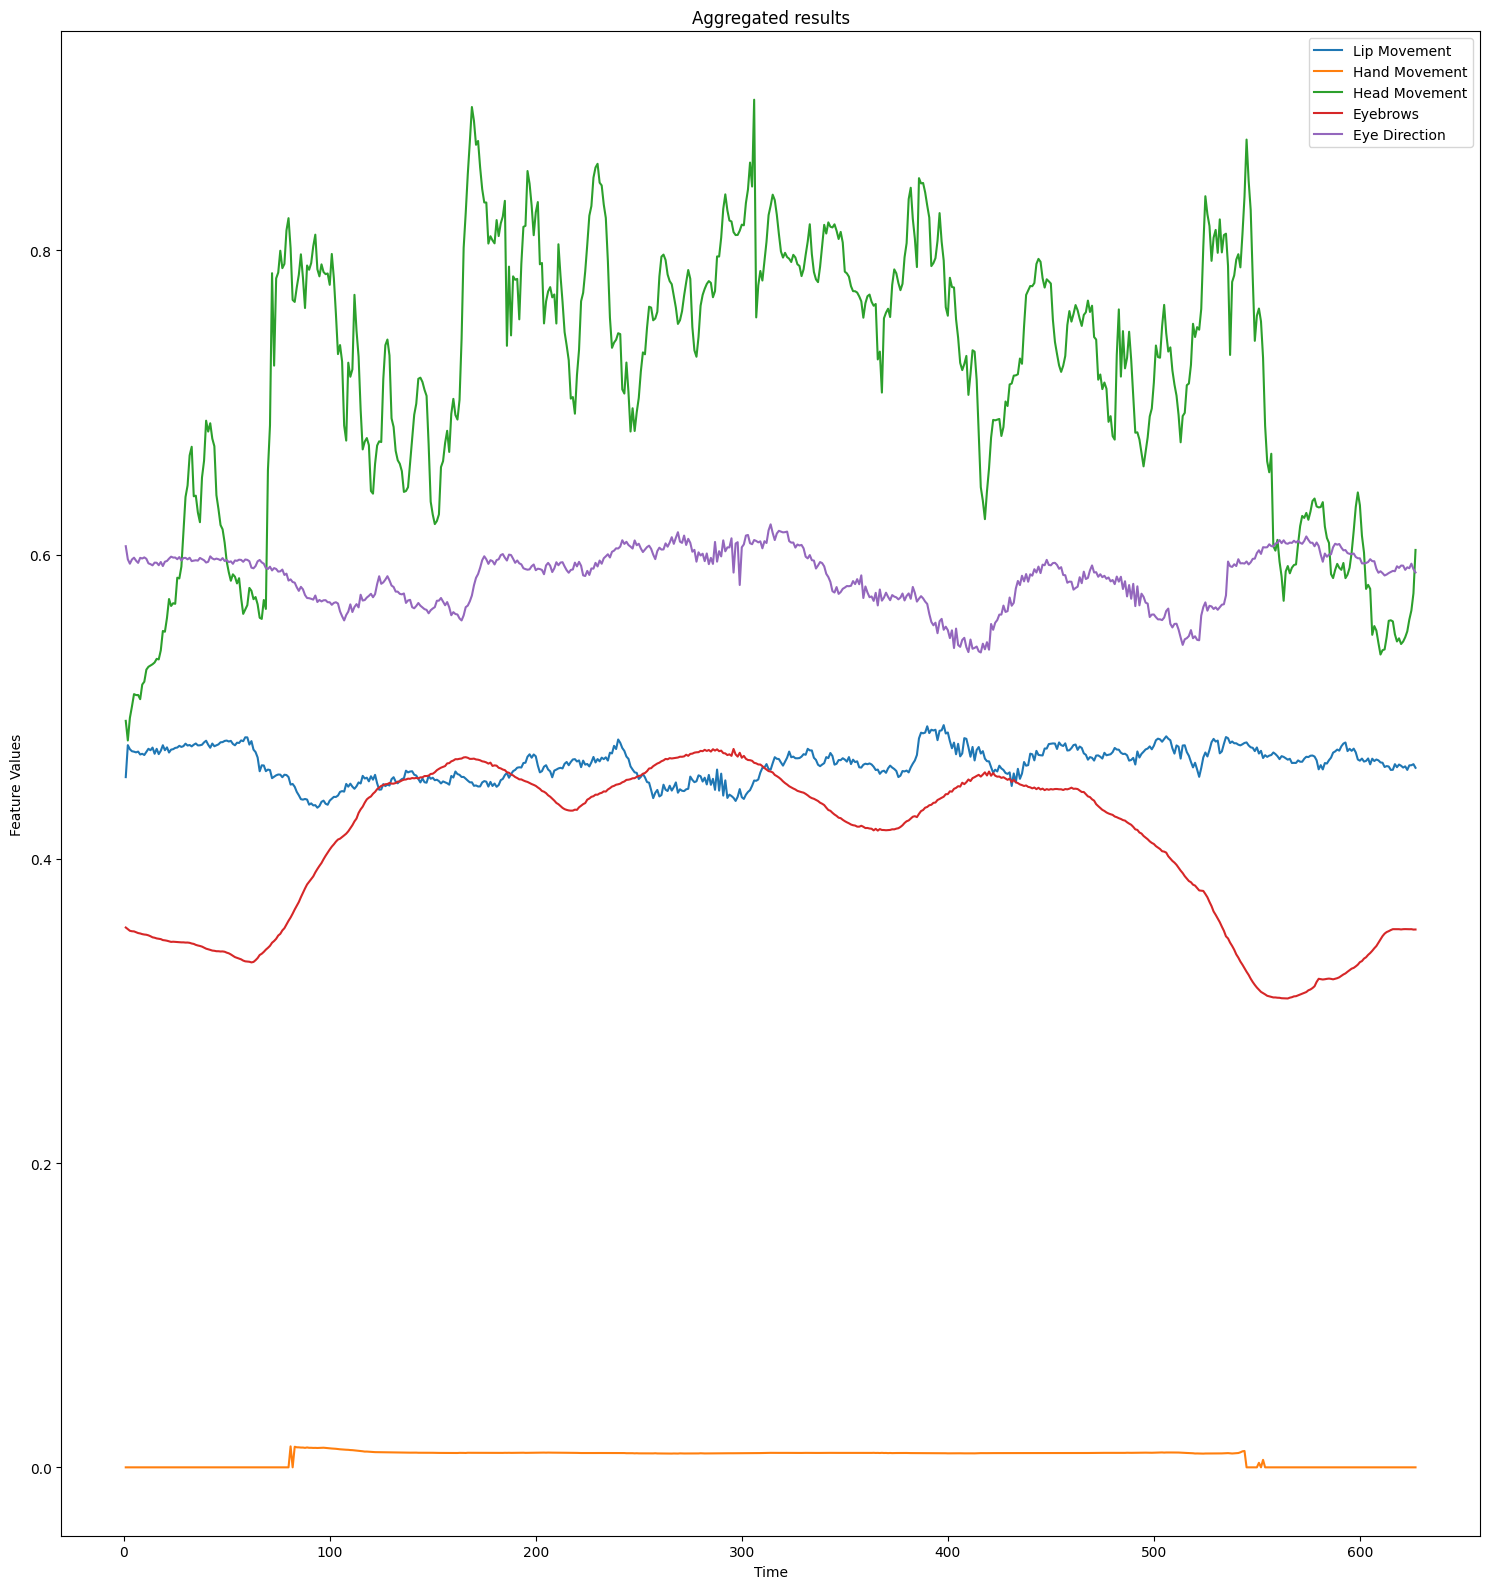

In [6]:
def process_video(video_path, feature_weights):
    cap = cv2.VideoCapture(video_path)  #lire la  video a partir du path

    with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh, \
            mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands, \
            mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:


        lip_movement_values = []
        hand_movement_values = []
        head_movement_values = []
        eyebrows_values = []
        eye_direction_values = []
        time_values = []

        frame_count = 0

        while cap.isOpened():
          # # Lecture d'une image de la vidéo
            ret, frame = cap.read()
            if not ret:
                break
            # Incrémentation du compteur d'images
            frame_count += 1
            # Obtention des dimensions de l'image
            frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
            frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Détection des traits du visage avec le détecteur Face Mesh
            results_face = face_mesh.process(rgb_frame)
            # Calcul du mouvement des lèvres
            lip_movement = calculate_lip_movement(results_face)

            # Mains: detection
            results_hands = hands.process(rgb_frame)
            hand_movement = calculate_hand_movement(results_hands, frame_width, frame_height)

            # Holistic (Head Movement, Eyebrows, Eye Direction)
            results_holistic = holistic.process(rgb_frame)
            head_movement = calculate_head_movement(results_holistic)
            eyebrows = calculate_eyebrows(results_holistic)
            eye_direction = calculate_eye_direction(results_holistic)

            # Collecter les valeurs des caractéristiques

            lip_movement_values.append(lip_movement)
            hand_movement_values.append(hand_movement)
            head_movement_values.append(head_movement)
            eyebrows_values.append(eyebrows)
            eye_direction_values.append(np.linalg.norm(eye_direction))
            time_values.append(frame_count)

        cap.release()


        # Plot  des  caractéristiques
        plt.figure(figsize=(15, 10))

        # Lip Movement
        plt.subplot(3, 2, 2)
        plt.plot(time_values, lip_movement_values, label='Lip Movement')
        plt.legend()
        plt.title(' Stress detected from Lip Movement ')

        # Hand Movement
        plt.subplot(3, 2, 3)
        plt.plot(time_values, hand_movement_values, label='Hand Movement')
        plt.legend()
        plt.title(' Stress detected from Hand Movement ')

        # Head Movement
        plt.subplot(3, 2, 4)
        plt.plot(time_values, head_movement_values, label='Head Movement')
        plt.legend()
        plt.title(' Stress detected from Head Movement ')

        # Eyebrows
        plt.subplot(3, 2, 5)
        plt.plot(time_values, eyebrows_values, label='Eyebrows')
        plt.legend()
        plt.title(' Stress detected from Eyebrows ')

        # Eye Direction
        plt.subplot(3, 2, 6)
        plt.plot(time_values, eye_direction_values, label='Eye Direction')
        plt.legend()
        plt.title(' Stress detected from Eye Direction ')

        plt.tight_layout()
        plt.show()

        # Affichege des valeurs maximales pour chacun des  features
        max_values = {
            'Lip Movement': max(lip_movement_values),
            'Hand Movement': max(hand_movement_values),
            'Head Movement': max(head_movement_values),
            'Eyebrows': max(eyebrows_values),
            'Eye Direction': max(eye_direction_values),
        }

        print("Maximum Feature Values:")
        for feature, max_value in max_values.items():
            print(f"{feature}: {max_value}")

        element_names = ['Lip Movement', 'Hand Movement', 'Head Movement', 'Eyebrows',  'Eye Direction']

        # Appel de la fonction generate_final_stress_description
        final_stress_description = generate_final_stress_description(max_values, element_names)
        # Affichage du résultat final
        print(final_stress_description)


        # Plot
        plt.figure(figsize=(15, 16))

        # Regroupement  des differents  caractériqtiques dans un seul graphe
        plt.plot(time_values, lip_movement_values, label='Lip Movement')
        plt.plot(time_values, hand_movement_values, label='Hand Movement')
        plt.plot(time_values, head_movement_values, label='Head Movement')
        plt.plot(time_values, eyebrows_values, label='Eyebrows')
        plt.plot(time_values, eye_direction_values, label='Eye Direction')

        plt.legend()
        plt.title('Aggregated results')
        plt.xlabel('Time')
        plt.ylabel('Feature Values')

        plt.tight_layout()
        plt.show()


video_path = "/content/Vid2.webm"
feature_weights = [1, 1, 1, 1, 1, 1]
process_video(video_path, feature_weights)


### **Conclusion**
Ce script fournit une analyse complète des niveaux de stress basée sur diverses caractéristiques faciales et corporelles.